In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib2tikz import save as tikz_save
# numpy (math) libary
import numpy as np


from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from os import walk

#path1 = '../../../data/2018_01_10/'
path1 = '../../../data/2018_01_12/'

# define settings for plots
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

### import iterator
from modules.iterate import *

In [3]:
history = 4
error = 1e-6
maxit = 2e3
history_weight = 0.25

ω_size = 9
ω_range  = np.linspace(w2f(1.55035e-6)/ω0, w2f(1.55055e-6)/ω0, ω_size) # [Hz/ω0]
E_size = 64
#E_range = np.power(np.logspace(0, 1.2, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
E_range = np.power(np.linspace(0, 10**1.2, num=E_size, endpoint=False), 0.5) # [10^x mW/mW]
#E_range = np.power(np.logspace(1.03, 1.037, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.append(np.logspace(-1, 1, num=E_size/2, endpoint=True),np.logspace(1.02, 1.05, num=E_size/2, endpoint=True)) , 0.5)
print(E_range**2)

[ 0.          0.24763956  0.49527912  0.74291868  0.99055825  1.23819781
  1.48583737  1.73347693  1.98111649  2.22875605  2.47639561  2.72403517
  2.97167474  3.2193143   3.46695386  3.71459342  3.96223298  4.20987254
  4.4575121   4.70515167  4.95279123  5.20043079  5.44807035  5.69570991
  5.94334947  6.19098903  6.43862859  6.68626816  6.93390772  7.18154728
  7.42918684  7.6768264   7.92446596  8.17210552  8.41974508  8.66738465
  8.91502421  9.16266377  9.41030333  9.65794289  9.90558245 10.15322201
 10.40086158 10.64850114 10.8961407  11.14378026 11.39141982 11.63905938
 11.88669894 12.1343385  12.38197807 12.62961763 12.87725719 13.12489675
 13.37253631 13.62017587 13.86781543 14.115455   14.36309456 14.61073412
 14.85837368 15.10601324 15.3536528  15.60129236]


In [4]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
u = {} # way up
u['Up']  = np.zeros( (ω_size,E_size,history), dtype=complex)
u['Us']  = np.zeros( (ω_size,E_size,history), dtype=complex)
u['Ut']  = np.zeros( (ω_size,E_size,history), dtype=float)
u['ΔN']  = np.zeros( (ω_size,E_size,history), dtype=float)
u['ΔT']  = np.zeros( (ω_size,E_size,history), dtype=float)
u['Δω']  = np.zeros( (ω_size,E_size,history), dtype=complex)
u['it']  = np.zeros( (ω_size,E_size), dtype=int)

### two nested for loops, in input power and in
for ω_i in range(ω_size):
        
    for E_i in range(E_size):
        
        ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        #ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, ñ𝛾FC, ñMCp, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñΓ, ñV, ñVeff)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        if E_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (u['Up'][ω_i,E_i-1,0], u['Us'][ω_i,E_i-1,0], u['Ut'][ω_i,E_i-1,0], u['ΔN'][ω_i,E_i-1,0], u['ΔT'][ω_i,E_i-1,0], u['Δω'][ω_i,E_i-1,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, ñequations, 2, error, maxit, history_weight)
                
        if new_var.shape[0] < history:
            new_var = np.vstack([ np.nan*np.zeros((history-new_var.shape[0],new_var.shape[1])), new_var ])
        
        u['Up'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 0]
        u['Us'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 1]
        u['Ut'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 2])
        u['ΔN'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 3])
        u['ΔT'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 4])
        u['Δω'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 5]
        u['it'][ω_i,E_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tP = %.2f mW"%(((1.0+ω_i)/ω_size*100),E_range[E_i]**2), end='')
        
    if loops:
        print("\r%3.1f %%\t\t%.2f nm \t%d \t%.1e"%((1.0+E_i)/E_size*100,f2w(ω_range[ω_i]*1e-9*ω0), max(u['it'][ω_i,:]), max(np.abs(u['Ut'][ω_i,:,0]-u['Ut'][ω_i,:,1]))) )
    #elif verbose:
    #print()

print("\nall loops have ended")

history weight 0.25
Completion	Power		max it	max error
100.0 %		1550.35 nm 	386 	1.0e-06
100.0 %		1550.37 nm 	614 	9.9e-07
100.0 %		1550.40 nm 	881 	1.0e-06
100.0 %		1550.42 nm 	877 	1.0e-06
100.0 %		1550.45 nm 	587 	9.9e-07
100.0 %		1550.47 nm 	340 	1.0e-06
100.0 %		1550.50 nm 	197 	9.6e-07
100.0 %		1550.52 nm 	317 	1.0e-06
100.0 %		1550.55 nm 	186 	9.9e-07

all loops have ended


In [5]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
d = {} # way down
d['Up']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['Us']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['Ut']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['ΔN']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['ΔT']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['Δω']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['it']  = np.zeros( (ω_size,E_size), dtype=int)

### two nested for loops, in input power and in
for ω_i in range(ω_size):
        
    for E_i in range(E_size):
        
        ñparams = (1.0, ω_range[ω_i], ñω0, E_range[-1-E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        #ñparams = (1.0, ω_range[ω_i], ñω0, E_range[-1-E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, ñ𝛾FC, ñMCp, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñΓ, ñV, ñVeff)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        if E_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (d['Up'][ω_i,-E_i,0], d['Us'][ω_i,-E_i,0], d['Ut'][ω_i,-E_i,0], d['ΔN'][ω_i,-E_i,0], d['ΔT'][ω_i,-E_i,0], d['Δω'][ω_i,-E_i,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, ñequations, 2, error, maxit, history_weight)
                
        if new_var.shape[0] < history:
            new_var = np.vstack([ np.nan*np.zeros((history-new_var.shape[0],new_var.shape[1])), new_var ])
        
        d['Up'][ω_i,-1-E_i,:]   = new_var[-1:-(history+1):-1, 0]
        d['Us'][ω_i,-1-E_i,:]   = new_var[-1:-(history+1):-1, 1]
        d['Ut'][ω_i,-1-E_i,:]   = np.real(new_var[-1:-(history+1):-1, 2])
        d['ΔN'][ω_i,-1-E_i,:]   = np.real(new_var[-1:-(history+1):-1, 3])
        d['ΔT'][ω_i,-1-E_i,:]   = np.real(new_var[-1:-(history+1):-1, 4])
        d['Δω'][ω_i,-1-E_i,:]   = new_var[-1:-(history+1):-1, 5]
        d['it'][ω_i,-1-E_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tP = %.2f mW"%(((1.0+ω_i)/ω_size*100),E_range[-1-E_i]**2), end='')
        
    if loops:
        print("\r%3.1f %%\t\t%.2f nm \t%d \t%.1e"%((1.0+E_i)/E_size*100,f2w(ω_range[ω_i]*1e-9*ω0), max(d['it'][ω_i,:]), max(np.abs(d['Ut'][ω_i,:,0]-d['Ut'][ω_i,:,1]))) )
    #elif verbose:
    #print()

print("\nall loops have ended")

history weight 0.25
Completion	Power		max it	max error
100.0 %		1550.35 nm 	430 	9.9e-07
100.0 %		1550.37 nm 	675 	1.0e-06
100.0 %		1550.40 nm 	914 	1.0e-06
100.0 %		1550.42 nm 	952 	9.9e-07
100.0 %		1550.45 nm 	613 	1.0e-06
100.0 %		1550.47 nm 	373 	9.9e-07
100.0 %		1550.50 nm 	219 	1.0e-06
100.0 %		1550.52 nm 	133 	9.9e-07
100.0 %		1550.55 nm 	73 	9.7e-07

all loops have ended


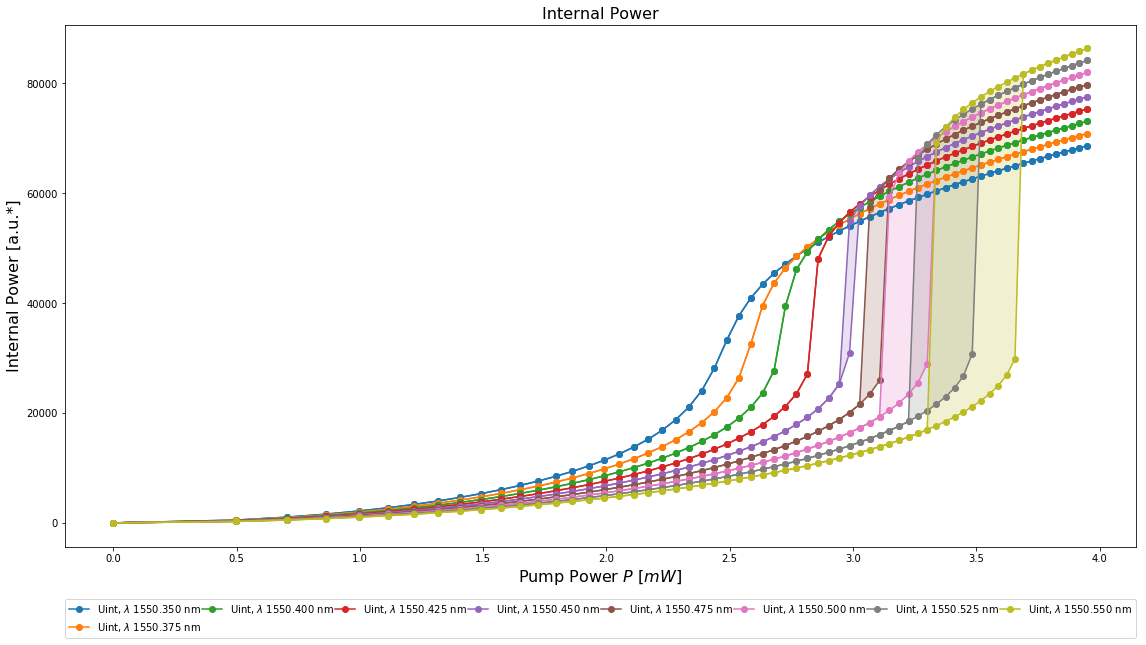

In [6]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

#ax1.set_ylim([5e3, 7.5e4])
#ax1.set_xlim([1549, 1551])

ul = []
dl = []
for ω_i in range(ω_size):
    #if E_i <= 3:
        #ax1.plot(E_range[:], np.abs(d['Up'][ω_i,:,0])**2, label='Up, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='-', marker='o')
        ul.append(
            ax1.plot(E_range, u['Ut'][ω_i,:,0], ls='-', marker='o',
                     label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)),
                    )
        )
        dl.append(
            ax1.plot(E_range, d['Ut'][ω_i,:,0], ls='-', marker='o', color=ul[-1][0].get_color() )
        )
        upp = u['Ut'][ω_i,:,0]
        downn = d['Ut'][ω_i,:,0]
        ax1.fill_between(E_range, downn, upp, where=downn>=upp, interpolate=True, color=ul[-1][0].get_color(), alpha=0.2)
        
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0], label='Uint, P %.3f mW'%E_range[E_i]**2, ls='-', marker='o')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,1], label='Uint', ls='--')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,2], label='Uint', ls='-.')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Us'][:,E_i,0], label='Uint', ls=':')
        
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0]-np.mean(d['Ut'][:,E_i,0]), label='Uint, P %.3f'%E_range[E_i]**2 ) 
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['Us'][:,E_i,0])**2, label='Us, P %.3fmW'%E_range[E_i]**2)

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
ax1.set_ylabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

#tikz_save('test.tex')

plt.show()
plt.close()

In [7]:
verbose = False

f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .tsv files from list
f = [x for x in f if x[-4:]==".tsv"]

# get length of filename list
f_len = len(f)

if verbose:
    for ii in range(f_len):
        print(ii, f[ii])

In [8]:
verbose = True

# exclude/add file section
f = [x for x in f if x[14:19]=="_full"]
#f = [f[1], f[3], f[6], f[8], f[10], f[12], f[15], f[17], f[20], f[23]]
f_len = len(f)

if verbose:
    print()
    for ii in range(f_len):
        print(ii, f[ii])


0 1558-VOA_sweep_full304.tsv
1 1604-VOA_sweep_full300.tsv
2 1611-VOA_sweep_full297.tsv
3 1617-VOA_sweep_full273.tsv
4 1623-VOA_sweep_full270.tsv
5 1636-VOA_sweep_full249.tsv
6 1641-VOA_sweep_full246.tsv
7 1647-VOA_sweep_full244.tsv
8 1648-VOA_sweep_full226.tsv
9 1700-VOA_sweep_full221.tsv
10 1705-VOA_sweep_full219.tsv
11 1707-VOA_sweep_full200.tsv
12 1711-VOA_sweep_full199.tsv
13 1716-VOA_sweep_full197.tsv
14 1725-VOA_sweep_full194.tsv


In [9]:
d1 = {} # empty data dictionary

for ff in range(f_len):
    temp = np.loadtxt(path1+f[ff])[0:3,0:2].reshape(6).tolist()
    temp[3:] = np.int_(temp[3:]) # convert to integer
    temp.append(temp[1]<temp[2]) # append direction_up value
    d1[ff] = ( temp, np.loadtxt(path1+f[ff])[3:,0:2] )
    del temp

# normalization constant
k = 0.2
    
if verbose:
    print('data shapes:')
    for ii, dd in d1.items():
        print(dd[1][:,:].shape, '-->\t %d loops, %d samples per loop' %(dd[1][:,:].shape[0]/dd[0][4]/2,2*dd[0][4]))
        print('\t\t',dd[0])
    print('\nnormalization constant k = %.1f'%k)

data shapes:
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.304, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.3, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.297, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.273, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.27, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.249, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.246, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.244, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.226, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.221, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 samples per loop
		 [1552.219, 0.0, 1.0, 1, 101, 100, True]
(202, 2) -->	 1 loops, 202 sample

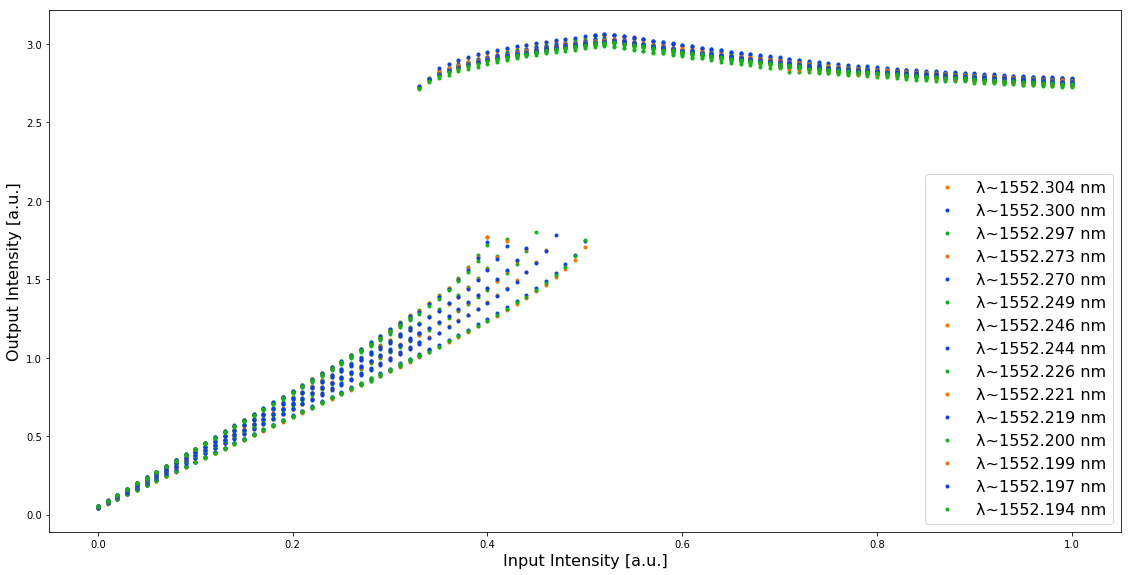

In [10]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

for ii, dd in d1.items():
    ax1.plot( dd[1][:,0], dd[1][:,1], label='λ~%.3f nm'%dd[0][0],#
              ls='', marker='.', c=colors[ii%3][0])

ax1.set_xlabel('Input Intensity [a.u.]', fontsize = 16)
ax1.set_ylabel('Output Intensity [a.u.]', fontsize = 16)
legend = ax1.legend(loc=4, fontsize=16)

plt.show()
plt.close()

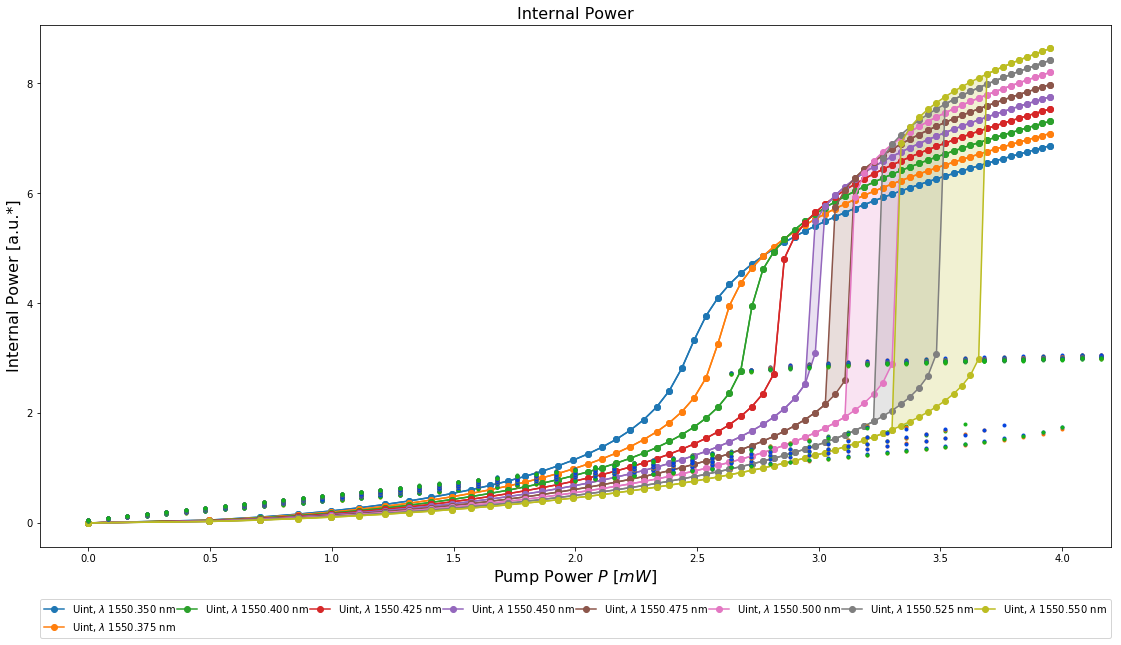

In [13]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

#ax1.set_ylim([5e3, 7.5e4])
ax1.set_xlim([-0.2, 4.2])

ul = []
dl = []
for ω_i in range(ω_size):
    ul.append(
        ax1.plot(E_range, 10e-5*u['Ut'][ω_i,:,0], ls='-', marker='o',
                 label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)),
                )
    )
    dl.append(
        ax1.plot(E_range, 10e-5*d['Ut'][ω_i,:,0], ls='-', marker='o', color=ul[-1][0].get_color() )
    )
    upp = 10e-5*u['Ut'][ω_i,:,0]
    downn = 10e-5*d['Ut'][ω_i,:,0]
    ax1.fill_between(E_range, downn, upp, where=downn>=upp, interpolate=True, color=ul[-1][0].get_color(), alpha=0.2)

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
ax1.set_ylabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

for ii, dd in d1.items():
    ax1.plot( dd[1][:,0]*8., dd[1][:,1], label='λ~%.3f nm'%dd[0][0],#
              ls='', marker='.', c=colors[ii%3][0])

plt.show()
plt.close()